In [3]:
import scipy as sp
import numpy as np
import pandas as pd
import timeit
import re
import json
import pickle
import fastparquet
import os
os.chdir('/mnt/t48/bighomes-active/sfeng/patentdiffusion/')
seed = 3
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
import datetime
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.iolib.summary2 as summary2
import dask.dataframe as dd
import dask.array as da
import itertools

/homedir/eco/sfeng/bigdata/python/miniconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)
logging.basicConfig(level=logging.INFO)
logger.addHandler(logging.FileHandler('Logs/pairsim_{0}.log'.format(datetime.datetime.now().\
                                                            strftime("%Y-%m-%d"), 'a')))
print = logging.info
print('good day to you madam fiona')
print('started')
print(datetime.datetime.now())

INFO:root:good day to you madam fiona
INFO:root:started
INFO:root:2018-07-23 01:11:06.497501


## 1. Similarity

See helpful code here: https://stackoverflow.com/questions/3992735/python-generator-that-groups-another-iterable-into-groups-of-n

In [3]:
def grouper(n, iterable):
    """
    >>> list(grouper(3, 'ABCDEFG'))
    [['A', 'B', 'C'], ['D', 'E', 'F'], ['G']]
    """
    iterable = iter(iterable)
    return iter(lambda: list(itertools.islice(iterable, n)), [])


In [4]:
import scipy.spatial.distance as distance
dms = ["ldavecs", "docvecs"]
files = ["DataStore/2018-07-P2/UniPats/uni_pats_samp_0722.pkl"]
out_files = ["DataStore/2018-07-P2/UniPats/uni_pats_sim_0722.pkl"]

for i,f in enumerate(files):
    print("Loading sample data")
    print(f)
    # 1. Load data
    l2 = pd.read_pickle(f)
    l2 = l2.drop_duplicates()
    print(len(l2))
    for dm in dms:
        print("Loading matrix and dict")
        print(datetime.datetime.now())

        pat_dict = fastparquet.ParquetFile("RawData/Cleaned/patabs7615_us_no_dup.parq").to_pandas(["patent"])["patent"].tolist()
        pat_dict = dict(zip(pat_dict, range(len(pat_dict))))
        # Store as dask array
        if dm == "ldavecs":
            ncols = 60
        else:
            ncols = 100
        pm = dd.read_parquet("DataStore/2018-07-P2/ML/{0}_pats_0712.parq".format(dm)).values.compute()
        pm = da.from_array(pm, chunks=(10000,ncols))

        print("Getting row values")
        print(datetime.datetime.now())
        #----------#
        # 2. Get pat vecs & pat similarity
        print(len(l2))
        # Remove missing values
        l3 = l2[["tp", "op"]].loc[l2["tp"].isin(pat_dict.keys()) & l2["op"].isin(pat_dict.keys())]

        if dm == "ldavecs":
            ncols = 60
        else:
            ncols = 100
        print(len(l3))

        print("Getting chunks")
        print(datetime.datetime.now())
        # Split into chunks
        n_rows = 3000
        n_chunks = int(np.round(len(l3)/n_rows))
        tp_chunks = grouper(n_rows, pm[[pat_dict[p] for p in l3["tp"].tolist()]].compute())
        op_chunks = grouper(n_rows, pm[[pat_dict[p] for p in l3["op"].tolist()]].compute())
        chunks = itertools.zip_longest(tp_chunks, op_chunks)

        print("Getting patent pair similarity")
        print("cosine")
        print(datetime.datetime.now())
        # Cosine

        cos_dis = np.empty(len(l3))

        for r, c in enumerate(chunks):
            cos_dis[r*n_rows:r*n_rows+n_rows] = np.diag(distance.cdist(c[0],c[1], metric = "cosine"))

        l3["sim_{0}".format(dm)] = 1-cos_dis
        del(cos_dis)

        l2 = l2.merge(l3[["tp", "op", "sim_{0}".format(dm)]], how = "left", on = ["tp", "op"])
        print(len(l2))           
        print("Finished {0}".format(dm))
        print(datetime.datetime.now())
    l2 = l2.drop_duplicates()
    print(len(l2))
    l2.to_pickle(out_files[i])
    

INFO:root:Loading sample data
INFO:root:DataStore/2018-07-P2/UniPats/uni_pats_samp_0722.pkl
INFO:root:Loading matrix and dict
INFO:root:2018-07-23 01:11:19.957176
INFO:root:Getting row values
INFO:root:2018-07-23 01:11:32.220174
INFO:root:795781
INFO:root:793404
INFO:root:Getting chunks
INFO:root:2018-07-23 01:11:32.743408
INFO:root:Getting patent pair similarity
INFO:root:cosine
INFO:root:2018-07-23 01:11:34.826904
INFO:root:971011
INFO:root:Finished this file
INFO:root:2018-07-23 01:12:44.880513
INFO:root:Loading matrix and dict
INFO:root:2018-07-23 01:12:44.881815
INFO:root:Getting row values
INFO:root:2018-07-23 01:13:04.421239
INFO:root:971011
INFO:root:968634
INFO:root:Getting chunks
INFO:root:2018-07-23 01:13:04.886482
INFO:root:Getting patent pair similarity
INFO:root:cosine
INFO:root:2018-07-23 01:13:07.520432
INFO:root:11289643
INFO:root:Finished this file
INFO:root:2018-07-23 01:15:19.391822


In [7]:
tr_out = ["DataStore/2018-07-P2/UniPats/uni_pats_samp_transformed_0722.pkl"]
pdf = fastparquet.ParquetFile("RawData/Cleaned/patent_loc_unique_us_0628.parq").to_pandas(\
                                    ["patent", "appyear", "gyear", "naics_name", "primclass", "inv_msa"]).drop_duplicates("patent")
uni_pats = pd.read_pickle("DataStore/2018-07-P2/UniPats/uni_pats_0722.pkl")["patent"]
ts = pd.read_pickle(out_files[0])    
ts = ts.merge(pdf.add_prefix("tp_"), how = "left", left_on="tp", right_on="tp_patent").drop("tp_patent",1)
print(len(ts))
ts = ts.merge(pdf.add_prefix("op_"), how = "left", left_on="op", right_on="op_patent").drop("op_patent",1)
print(len(ts))
del(pdf)
# Add year diff
ts["year_diff"] = ts["op_appyear"] - ts["tp_appyear"]
# Add if software
ts["tp_is_uni"] = ts["op_is_uni"] = False
ts.loc[ts["tp"].isin(uni_pats.tolist()), "tp_is_uni"] = True
ts.loc[ts["op"].isin(uni_pats.tolist()), "op_is_uni"] = True

for c in ["naics_name", "primclass", "inv_msa"]:
    ts["{0}_match".format(c)] = (ts["tp_{0}".format(c)] == ts["op_{0}".format(c)])

eps = 0.01
dv_min = 0.7
def scale_docvecs(x):
    scaled = ((x+dv_min)/(1+dv_min))*(1-eps)+eps
    return scaled
def scale_ldavecs(x):
    scaled = x*(1-eps)+eps
    return scaled
ts["sim_ldavecs"] = ts["sim_ldavecs"].apply(scale_ldavecs)
ts["sim_docvecs"] = ts["sim_docvecs"].apply(scale_docvecs)

ts.to_pickle(tr_out[0])



INFO:root:752390
INFO:root:752390


____

## 2. University patent similarity

1. Average similarity for all target patents for (i) in MSA and (ii) in Field
2. Plot Not Samp target patents similarity to the "in field" sample
3. Plot Samp target patents similarity to the "in field" sample
4. For each year, Get difference of 2 & 3; also p-value of significance of difference
5. Plot Not Samp target patents similarity to the "in MSA" sample
6. Plot Samp target patents similarity to the "in MSA" sample
7. For each target, get difference between "in MSA" to "in field" and plot. Also p-value of significance of difference

In [28]:
tr_out = ["DataStore/2018-07-P2/UniPats/uni_pats_samp_transformed_0722.pkl"]
ts = pd.read_pickle(tr_out[0])
yr_min = 1975
yr_max = 1989
ts = ts.loc[ts["tp_appyear"].isin(range(yr_min,yr_max+1))]
print(len(ts))
# Get rid of comparision to other uni patents
ts = ts.loc[ts["tp_appyear"].isin(range(yr_min,yr_max+1)) & (ts["op_is_uni"] == False)]
print(len(ts))

752390
734257


In [32]:
# Average by target patent similarity
k = "tp_is_uni"
yr = "tp_appyear"

res = pd.DataFrame()
cols = ["tp", "tp_is_uni", "samp", "inv_msa_match", "tp_appyear", "tp_primclass",\
        "sim_ldavecs", "sim_docvecs", "year_diff"]
# Split dataframe into relevant sample groups: (samp, in field), (samp, in msa), 
# (nonsamp, in field), (nonsamp, in msa)
tp_sim = ts[cols].groupby(["tp", "samp"]).mean().reset_index().dropna(how="any")
tp_samp_field = tp_sim.loc[(tp_sim[k] == True) & (tp_sim["samp"] == "In Field")]
tp_nonsamp_field = tp_sim.loc[(tp_sim[k] == False) &(tp_sim["samp"] == "In Field")]

# Get mean similarity of each target by msa match
tp_sim_msa = ts[cols].groupby(["tp", "inv_msa_match"]).mean().reset_index()

############
# 1. In Samp Localization
# Average similarity for each target, msa match = True
tp_T = tp_sim_msa.loc[(tp_sim_msa[k] == True) &(tp_sim_msa["inv_msa_match"] == True)]\
.copy().set_index("tp").rename(columns={"sim_ldavecs": "msa_sim_ldavecs", "sim_docvecs": "msa_sim_docvecs"})

# Average similarity for each target, msa match = False
tp_F = tp_sim_msa.loc[(tp_sim_msa[k] == True) &(tp_sim_msa["inv_msa_match"] == False),\
["tp", "sim_ldavecs", "sim_docvecs"]].copy().set_index("tp").rename(columns={\
                                "sim_ldavecs": "nonmsa_sim_ldavecs", "sim_docvecs": "nonmsa_sim_docvecs"})

# Merge on tp
tp_msa = pd.concat([tp_T, tp_F], axis=1).reset_index().dropna(how="any")
# Get similarity difference between similarity msa match & non match
tp_msa["sim_ldavecs_diff"] = tp_msa["msa_sim_ldavecs"]-tp_msa["nonmsa_sim_ldavecs"]
tp_msa["sim_docvecs_diff"] = tp_msa["msa_sim_docvecs"]-tp_msa["nonmsa_sim_docvecs"]

tp_samp_msa = tp_msa

############
# 2. Out Samp Localization
# Average similarity for each target, msa match = True
tp_T = tp_sim_msa.loc[(tp_sim_msa[k] == False) &(tp_sim_msa["inv_msa_match"] == True)]\
.copy().set_index("tp").rename(columns={"sim_ldavecs": "msa_sim_ldavecs", "sim_docvecs": "msa_sim_docvecs"})

# Average similarity for each target, msa match = False
tp_F = tp_sim_msa.loc[(tp_sim_msa[k] == False) &(tp_sim_msa["inv_msa_match"] == False),\
["tp", "sim_ldavecs", "sim_docvecs"]].copy().set_index("tp").rename(columns={\
                                "sim_ldavecs": "nonmsa_sim_ldavecs", "sim_docvecs": "nonmsa_sim_docvecs"})

# Merge on tp
tp_msa = pd.concat([tp_T, tp_F], axis=1).reset_index().dropna(how="any")
# Get similarity difference between similarity msa match & non match
tp_msa["sim_ldavecs_diff"] = tp_msa["msa_sim_ldavecs"]-tp_msa["nonmsa_sim_ldavecs"]
tp_msa["sim_docvecs_diff"] = tp_msa["msa_sim_docvecs"]-tp_msa["nonmsa_sim_docvecs"]

tp_nonsamp_msa = tp_msa

del(tp_T, tp_F, tp_msa)

In [35]:
out = {}
for dm in ["sim_ldavecs", "sim_docvecs"]:
    res = pd.DataFrame(index=range(yr_min,yr_max+1))
    
    # 1. Time series of mean similarity in field
    tgs = tp_samp_field[[dm, yr]].groupby([yr])
    tgn = tp_nonsamp_field[[dm, yr]].groupby([yr])
    
    # Mean & Std
    res["samp_field_sim_mean"] = tgs.mean()[dm]
    res["samp_field_sim_std"] = tgs.std()[dm]
    
    res["nonsamp_field_sim_mean"] = tgn.mean()[dm]
    res["nonsamp_field_sim_std"] = tgn.std()[dm]
    
    # Difference
    res["samp_field_diff"] = res["samp_field_sim_mean"] - res["nonsamp_field_sim_mean"]
    
    # p-value of difference
    res["field_diff_pval"] = [sp.stats.ttest_ind(g[dm], tgn.get_group(n)[dm], equal_var=False)[1]\
                              for n,g in tgs]
    
    # 2. Time series of mean similarity in MSA
#     c = "msa_{0}".format(dm)
    c = "{0}_diff".format(dm)
    tgs = tp_samp_msa[[c, yr]].groupby([yr])
    tgn = tp_nonsamp_msa[[c, yr]].groupby([yr])
    
    # Mean & Std
    res["samp_local_mean"] = tgs.mean()[c]
    res["samp_local_std"] = tgs.std()[c]
    
    res["nonsamp_local_mean"] = tgn.mean()[c]
    res["nonsamp_local_std"] = tgn.std()[c]
    
    # Difference
    res["samp_msa_diff"] = res["samp_local_mean"] - res["nonsamp_local_mean"]
    
    # p-value of difference
    res["msa_diff_pval"] = [sp.stats.ttest_ind(g[c], tgn.get_group(n)[c],
                                               equal_var=False)[1] for n,g in tgs]
    out[dm] = res

#### Tables

In [36]:
k = "Uni"
res = out["sim_docvecs"]
cols = ["samp_local_mean", "samp_local_std", "nonsamp_local_mean", "nonsamp_local_std",
                    "samp_msa_diff", "msa_diff_pval"]
# ncols = ["Local Sim Mean, {0} Patents".format(k), "Std Dev, {0} Patents".format(k), 
#          "Local Sim Mean, Other Patents", "Std Dev, Other Patents",
#                     "Diff", "$p$-value"]
ncols = ["Mean Localization, {0} Patents".format(k), "Std Dev, {0} Patents".format(k), 
         "Mean Localization, Other Patents", "Std Dev, Other Patents",
                    "Diff", "$p$-value"]
res2 = np.round(res[cols].rename(columns=dict(zip(cols,ncols))),3)

display(res2)

,"Mean Localization, Uni Patents","Std Dev, Uni Patents","Mean Localization, Other Patents","Std Dev, Other Patents",Diff,$p$-value
1975,0.004,0.027,0.005,0.037,-0.001,0.687
1976,0.001,0.046,0.005,0.040,-0.004,0.406
1977,-0.000,0.046,0.006,0.048,-0.006,0.175
1978,0.006,0.062,0.005,0.054,0.001,0.851
1979,-0.015,0.074,0.005,0.071,-0.020,0.022
1980,-0.003,0.039,0.005,0.039,-0.008,0.007
1981,0.004,0.036,0.005,0.044,-0.001,0.688
1982,0.003,0.050,0.004,0.048,-0.001,0.737
1983,-0.002,0.068,0.005,0.057,-0.007,0.185
1984,0.002,0.076,0.005,0.074,-0.002,0.704


In [37]:
print(res2.to_latex(escape=False,column_format="lcccccc"))

\begin{tabular}{lcccccc}
\toprule
{} &  Mean Localization, Uni Patents &  Std Dev, Uni Patents &  Mean Localization, Other Patents &  Std Dev, Other Patents &   Diff &  $p$-value \\
\midrule
1975 &                           0.004 &                 0.027 &                             0.005 &                   0.037 & -0.001 &      0.687 \\
1976 &                           0.001 &                 0.046 &                             0.005 &                   0.040 & -0.004 &      0.406 \\
1977 &                          -0.000 &                 0.046 &                             0.006 &                   0.048 & -0.006 &      0.175 \\
1978 &                           0.006 &                 0.062 &                             0.005 &                   0.054 &  0.001 &      0.851 \\
1979 &                          -0.015 &                 0.074 &                             0.005 &                   0.071 & -0.020 &      0.022 \\
1980 &                          -0.003 &                 0.

In [38]:
%matplotlib inline
sns.set(font_scale=1.4)
sns.set_style("ticks")
plt.rcParams["font.family"] = "Liberation Sans"
plt.rcParams.update({'font.size': 20})
savepath = "DataStore/2018-07-P3/ResultsGraphs/"
def p1(x, y, hue, data, bars, order, ax): 
    g = sns.pointplot(x = x, y = y, hue = hue, 
                data = data, ci = bars, markers = ".", 
                order = order, dodge = True, errwidth = 1,
                palette = sns.color_palette("Greys_r", 3),
                n_boot = 100,      
                  ax = ax)
    sns.despine()
    return g

    
def p2(x, y, data, order, ax, conf_int = None):
    g = sns.pointplot(x=x, y=y, data = data, ci = conf_int, join = True,
                 order = order, markers = ".", color="grey", ax = ax)
    sns.despine()
    return g
c_dict = pickle.load(open("DataStore/2018-06/col_names_dict.pkl", "rb"))

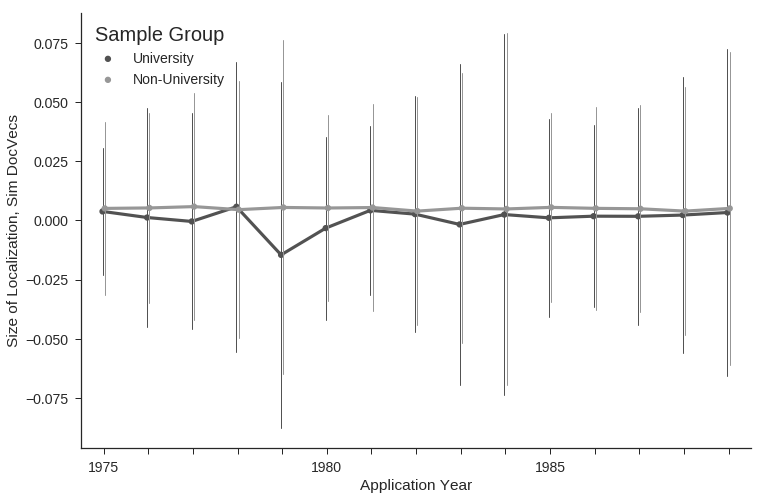

In [39]:
k = "University"
dm = "sim_docvecs"
# c = "msa_{0}".format(dm)
c = "{0}_diff".format(dm)
a = tp_samp_msa[[c, yr]].copy()
a["samp"] = k
b = tp_nonsamp_msa[[c, yr]].copy()
b["samp"] = "Non-{0}".format(k)
df = a.append(b, ignore_index=True)

x1 = "tp_appyear"
y1 = c
hue1 = "samp"
order1 = None
conf_int1 = "sd"
df[x1] = df[x1].astype(int)
fig, ax = plt.subplots(figsize=(12,8))
g3 = p1(x = x1, y = y1, order = order1, data = df, bars = conf_int1, hue = hue1, ax = ax)
g3.legend(loc='upper left', title = c_dict[hue1])

ax.set_xlabel(c_dict[x1])
ax.set_ylabel(c_dict[y1])

# Get every 5 years
plt.setp(g3.get_xticklabels(), visible=False)
plt.setp(g3.get_xticklabels()[::5], visible=True)
plt.savefig(savepath+"2b-UniLocalSim.png")
plt.show()
del(fig, ax)

In [41]:
ts.loc[ts["tp_appyear"] == 1979, "tp_gyear"].value_counts()

1981    6115
1980    5912
1982     385
1979      99
1983      16
1984       6
1985       2
1987       1
Name: tp_gyear, dtype: int64